In [1]:
import tensorflow as tf
tf.executing_eagerly()

True

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from stog.utils.params import Params
from stog.data.dataset_builder import dataset_from_params, iterator_from_params
from stog.data.vocabulary import Vocabulary
from stog.training.trainer import Trainer
from stog.data.dataset import Batch
from model.text_to_amr import TextToAMR

from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError

[2020-03-18 17:52:54,185 INFO] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [4]:
params = Params.from_file("../model/model_params.yaml")

/home/adylanrff/Documents/Kuliah/TA/amr_parser/stog/utils/params.py:104: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dict_merge.dict_merge(params_dict, yaml.load(f))


In [5]:
data_params = params['data']
dataset = dataset_from_params(data_params)

[2020-03-18 17:52:54,262 INFO] Building train datasets ...
[2020-03-18 17:52:54,265 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn't find any file associated to this path or url.
0it [00:00, ?it/s][2020-03-18 17:52:54,267 INFO] Reading instances from lines in file at: ../data/raw/amr.txt.features
[2020-03-18 17:52:54,326 INFO] POS tag coverage: 0.3087 (184/596)
40it [00:00, 672.71it/s]
[2020-03-18 17:52:54,327 INFO] Building dev datasets ...
[2020-03-18 17:52:54,328 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-

In [6]:
train_data = dataset['train']
dev_data = dataset.get('dev')
test_data = dataset.get('test')

In [7]:
vocab_params = params.get('vocab', {})
vocab = Vocabulary.from_instances(instances=train_data, **vocab_params)
vocab.save_to_files("../data/processed/serialization")

dataset = Batch(train_data)
dataset.index_instances(vocab)
dataset.index_instances(vocab)

# print(dataset.as_tensor_dict()['src_tokens']['encoder_tokens'][1].numpy())
# print(dataset.as_tensor_dict()['tgt_tokens']['decoder_tokens'][1].numpy())
# print(dataset.get_padding_lengths())
# print(dataset.as_tensor_dict())

for key in dataset.as_tensor_dict():
    print(key)
    content = dataset.as_tensor_dict()[key]
    if isinstance(content, dict):
        for inner_key in content:
            print("  ", inner_key)

train_iterator, dev_iterater, test_iterater = iterator_from_params(vocab, data_params['iterator'])

train_dataset = Batch(train_data)
train_dataset.index_instances(vocab)

test_dataset = Batch(test_data)
test_dataset.index_instances(vocab)

train_dataset = train_dataset.as_tensor_dict()
test_dataset = test_dataset.as_tensor_dict()

[2020-03-18 17:52:54,452 INFO] Fitting token dictionary from dataset.
100%|██████████| 40/40 [00:00<00:00, 2420.15it/s]
[2020-03-18 17:52:54,472 WARNING] vocabulary serialization directory ../data/processed/serialization is not empty


src_tokens
   encoder_tokens
   encoder_characters
src_must_copy_tags
tgt_tokens
   decoder_tokens
   decoder_characters
src_pos_tags
tgt_pos_tags
tgt_copy_indices
tgt_copy_mask
tgt_copy_map
src_copy_indices
src_copy_map
head_tags
head_indices


In [8]:
print(vocab)

Vocabulary with namespaces:
 	Non Padded Namespaces: {'coref_tags', 'must_copy_tags'}
 	Namespace: encoder_token_ids, Size: 334 
 	Namespace: encoder_token_characters, Size: 39 
 	Namespace: decoder_token_ids, Size: 283 
 	Namespace: decoder_token_characters, Size: 65 
 	Namespace: pos_tags, Size: 16 
 	Namespace: head_tags, Size: 35 



###### Test Model

In [9]:
text_to_amr = TextToAMR(vocab)
encoder_input, decoder_input, generator_input, parser_input = text_to_amr.prepare_input(train_dataset)

ENCODER_INPUT
bert_token: None
token_subword_index: None
token: (40, 25)
pos_tag: (40, 25)
must_copy_tag: (40, 25)
char: (40, 25, 14)
mask: torch.Size([40, 25])

DECODER_INPUT
token: (40, 28)
pos_tag: (40, 28)
char: (40, 28, 17)
coref: (40, 28)

GENERATOR_INPUT
vocab_targets: (40, 28)
coref_targets: (40, 28)
coref_attention_maps: (40, 28, 29)
copy_targets: (40, 28)
copy_attention_maps: (40, 25, 27)

PARSER_INPUT
edge_heads: (40, 28)
edge_labels: (40, 28)
corefs: (40, 28)
mask: (40, 28)



In [10]:
token_encoder_input = encoder_input.get('token')
pos_encoder_input = encoder_input.get('pos_tag')
token_decoder_input = decoder_input.get('token')
pos_decoder_input = decoder_input.get('pos_tag')

copy_attention_map_input = generator_input.get('copy_attention_maps')
coref_attention_map_input = generator_input.get('coref_attention_maps')
vocab_target_input  = generator_input.get('vocab_targets')
coref_target_input  = generator_input.get('coref_targets')
copy_target_input  = generator_input.get('copy_targets')

edge_heads_input = parser_input.get('edge_heads')
edge_labels_input = parser_input.get('edge_labels')
parser_mask_input = parser_input.get('mask')
coref_input = parser_input.get('corefs')


# token_encoder_input, 
# pos_encoder_input, 
# token_decoder_input, 
# pos_decoder_input, 
# copy_attention_maps_input, 
# coref_attention_maps_input,
# mask_input,
# edge_heads_input,
# edge_labels_input,
# corefs_input,

model_input = [
    token_encoder_input, 
    pos_encoder_input, 
    token_decoder_input, 
    pos_decoder_input, 
    copy_attention_map_input, 
    coref_attention_map_input,
    parser_mask_input, 
    edge_heads_input,
    edge_labels_input,
    coref_input,
    vocab_target_input,
    coref_target_input,
    copy_target_input
]

model_input = [e.astype('int32') for e in model_input]

In [16]:
total_losses = []
token_losses = []
edge_losses = []

EPOCHS = 200

for epoch in range(EPOCHS):
    loss, token_loss, edge_loss = text_to_amr.train(model_input)
    total_losses.append(loss)
    token_losses.append(token_loss)
    edge_losses.append(edge_loss)
    print("EPOCH: {}, TOKEN LOSS: {:.4f}, EDGE LOSS: {:.4f}, TOTAL LOSS: {:.4f}".format(epoch,\
                                             float(token_loss.numpy()), \
                                             float(edge_loss.numpy()), \
                                            float(loss.numpy())), end='\r')

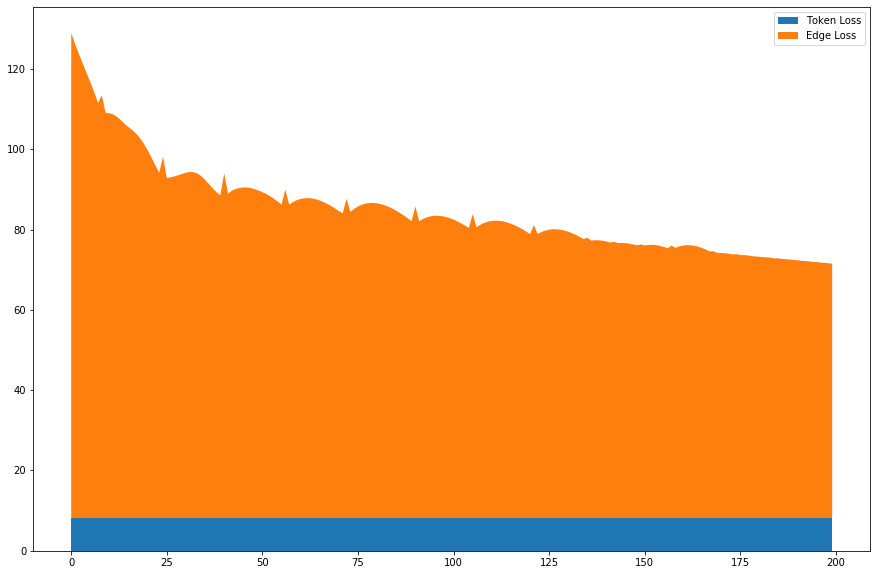

In [17]:
plt.stackplot([i for i in range(EPOCHS)], token_losses, edge_losses, labels=['Token Loss', 'Edge Loss'])
plt.legend()
plt.show()

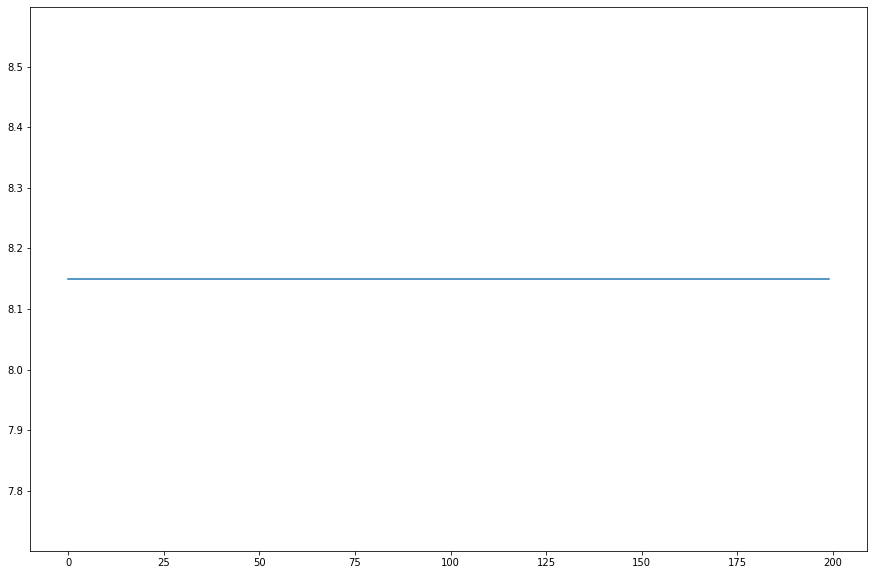

In [18]:
plt.plot(token_losses)
plt.show()

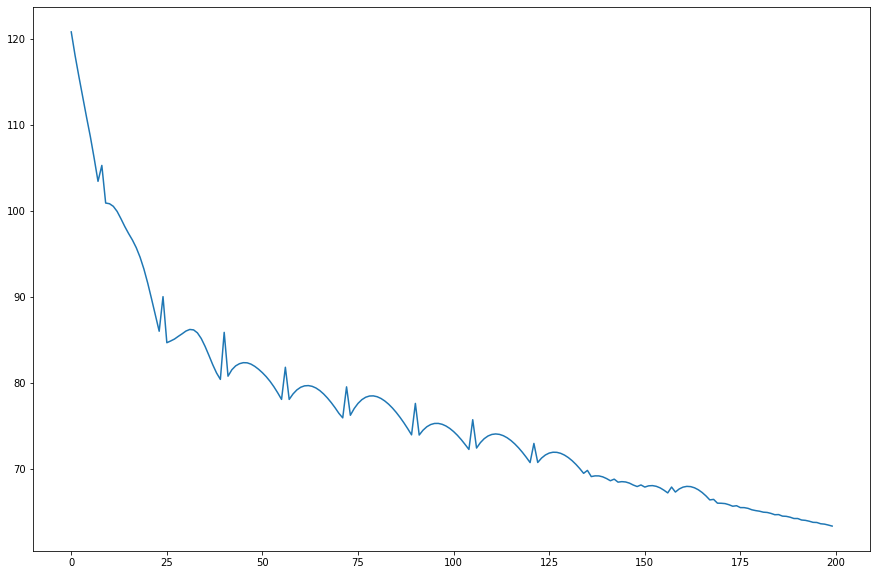

In [19]:
plt.plot(edge_losses)
plt.show()